# 2. Feature Selection

From the EDA results, we show a number of highly correlated features pairs. This prompt us to do feature engineering and remove at least one in each pair if possible without affecting the model's performance.
For our baseline model, SVM model is selected as it is a simple linear model and provides benchmark against the performance of more complex models used later on.

We will use 3 feature selection methods from scikit-learn to be compare within the baseline SVM model using the evaluation metrics of accuracy score, percision, recall and F1-score.
- method 1: SelectKBest
- method 2: Principal Component Analysis (PCA)
- method 3: DecisionTree's Feature Importance

The following block of code loads the data, relevant packages and defines a helper function for quick evaluation of different feature selection used for the baseline model.

In [2]:
#import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly
import math

#load the data
curr_dir=os.getcwd()
f_path = os.path.join(curr_dir, "data", "cancer patient data sets.csv")

df=pd.read_csv(f_path)
features = df.drop(["index","Patient Id","Level"], axis=1)
features.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Coughing of Blood,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring
0,33,1,2,4,5,4,3,2,2,4,...,4,3,4,2,2,3,1,2,3,4
1,17,1,3,1,5,3,4,2,2,2,...,3,1,3,7,8,6,2,1,7,2
2,35,1,4,5,6,5,5,4,6,7,...,8,8,7,9,2,1,4,6,7,2
3,37,1,7,7,7,7,6,7,7,7,...,8,4,2,3,1,4,5,6,7,5
4,46,1,6,8,7,7,7,6,7,7,...,9,3,2,4,1,4,2,4,2,3


In [3]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X=features
y=df["Level"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# A Naive SVM linear model will be used as benchmark of the feature selection.
def give_baseline_accuracy(feature_selection):
    X_train_subset = X_train[feature_selection]
    X_test_subset = X_test[feature_selection]
    linear_clf = svm.SVC(kernel="linear", decision_function_shape='ovo', probability=True)
    linear_clf.fit(X_train_subset, y_train)
    y_pred = linear_clf.predict(X_test_subset)
    accuracy_ = accuracy_score(y_test, y_pred)
    #print("Accuracy: ", accuracy)
    return(accuracy_)

# Check accuracy using all features
give_baseline_accuracy(features.columns)


1.0

The baseline accuracy without any feature selection is 1. The following section will explore selections of features to see if it affects the accuracy.

## Method 1: SelectKBest

SelectKBest is a feature selection technique commonly used in machine learning to choose the top 'k' most informative features from a dataset based on their statistical significance. It operates by scoring individual features using a specified scoring function, such as chi-squared, ANOVA F-value, or mutual information, and selecting the 'k' features with the highest scores.

The following block of code generates the 10 best features and evaluates them according to the baseline model. Correlation of the accuracy and number of k is also visualized.

Features:
Index(['Air Pollution', 'Alcohol use', 'Dust Allergy', 'OccuPational Hazards',
       'Genetic Risk', 'Balanced Diet', 'Obesity', 'Passive Smoker',
       'Chest Pain', 'Coughing of Blood'],
      dtype='object')
default params: 0.925


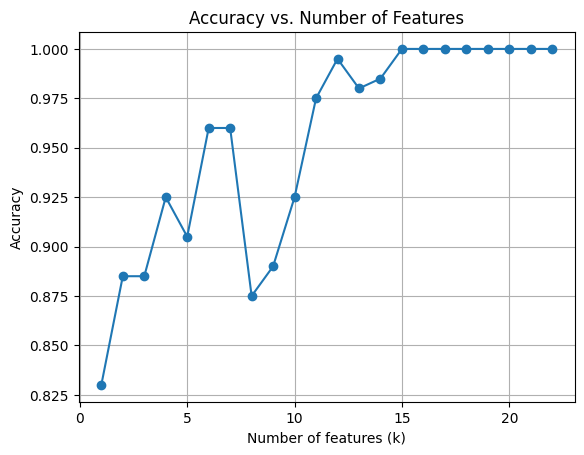

In [5]:
from sklearn.feature_selection import SelectKBest
X_train_2 , X_test_2, y_train_2, y_test_2=X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

#default parameters
select_k_best=SelectKBest()
x_col=select_k_best.fit_transform(X_train_2,y_train_2)
features_selected_method1=X_train_2.columns[select_k_best.get_support()]
print("Features:")
print(features_selected_method1)
accuracy_=give_baseline_accuracy(features_selected_method1)
print(f"accuracy with default params: {accuracy_}")

import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest

# Initialize lists to store k values and corresponding accuracies
k_values = []
accuracies = []

# Iterate over different values of k
for i in range(1, 23):
    select_k_best = SelectKBest(k=i)
    x_col = select_k_best.fit_transform(X_train_2, y_train_2)
    features_selected_method1 = X_train_2.columns[select_k_best.get_support()]
    accuracy = give_baseline_accuracy(features_selected_method1)
    
    # Store k value and accuracy
    k_values.append(i)
    accuracies.append(accuracy)

# Plot the results
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of features (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Features')
plt.grid(True)
plt.show()


_Fig 2-1. Baseline model accuracy against number of features for SelectKBest feature selection._

SelectKBest selects features using a statistical method such as the default ANOVA F-test for classification problems. It then selects k highest scoring features.  It defaults to k=10, the limited number of k probably explains why the accuracy goes down compared to the baseline. Using a higher k value generally leads to higher accuracy (Fig 2-1).

## Method 2: Principal Component Analysis (PCA)

Principal Component Analysis is an unsupervised learning method used for dimensionality reduction. By identifying the principal components (PC), which are linear combinations of the original variables, PCA simplifies complex datasets, and reveals underlying structures.

Since principal components maximizes capturing the variance of the data, a PCA plot can help visualize the overall linear relationship between the datapoints. The following subsection will visualize the PCA plot, and then extract the features that make up the principal components.

Note: top 5 features from each principal component will be extracted.
- Method 2a: Uses 2 PC
- Method 2b: Uses 3 PC

In [4]:
x = features
y=df["Level"]
n_comp=10
pc_list = [f"PC{i+1}" for i in range(n_comp)]

from sklearn import decomposition
pca = decomposition.PCA(n_components=n_comp)
pc = pca.fit_transform(x)
pc_df = pd.DataFrame(data=pc,columns=pc_list)
pc_df['Label'] = y

var = pd.DataFrame({'Variance':pca.explained_variance_ratio_,
             'PC':pc_list})

#txt = "figure caption"

#Make a 3D plot for the PC
import plotly.express as plotly_express
figure = plotly_express.scatter_3d(pc_df,x="PC1",y="PC2",z="PC3",color="Label",)
figure.update_layout(showlegend=True,
                     scene=dict(
                         xaxis_title="PC1 ("+ str(round(var['Variance'][0]*100,2)) + "%)",
                         yaxis_title="PC2 ("+ str(round(var['Variance'][1]*100,2)) + "%)",
                         zaxis_title="PC3 ("+ str(round(var['Variance'][2]*100,2)) + "%)"
                     ))
#figure.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
figure.show()


_Fig 2-2. 3D PCA plot showing the first 3 principal components of the Lung Cancer Prediction features._

From the 3d plot, the 1st, 2nd, and 3rd PC contributes to 59.54%, 18.00% and 5.49% of variance respectively.
Even from using PC1 and PC2 alone, it accounts for 77.6% of the variance (Fig2-2).

The following block of code takes the most important features from 2 PCs.

In [5]:
n_pcs = 2

model = decomposition.PCA(n_components=n_pcs).fit(X_train)
f_ordered = [np.argsort(model.components_[i]) for i in range(n_pcs)]
feature_names = features.columns
f = []
for i in range(n_pcs):
    x = [feature_names[j] for j in f_ordered[i]]
    f.append(x)
# 5 most important features in each PC 
# get the last 5 features (features sorted in increasing order of importance)
# reverse list to sort by most important 
ls = [f[i][-5:][::-1] for i in range(n_pcs)]
data = [['PC{}'.format(i)]+ls[i] for i in range(n_pcs)]
df_features = pd.DataFrame(data,columns=["PC",1,2,3,4,5])
final_features = ls[0] + ls[1]
final_features_method2a = list(dict.fromkeys(final_features))
print("Features:")
print(final_features_method2a)
# baseline_accuracy(final_features_method2a)
method2a_accuracy=give_baseline_accuracy(final_features_method2a)
print(f"Accuracy: {method2a_accuracy}")

Features:
['Age', 'Alcohol use', 'Smoking', 'chronic Lung Disease', 'Fatigue', 'Coughing of Blood', 'Chest Pain', 'Genetic Risk', 'OccuPational Hazards']
Accuracy: 0.945


The following block of code takes the most important features from 3 PCs.

In [6]:
n_pcs = 3

model = decomposition.PCA(n_components=n_pcs).fit(X_train)
f_ordered = [np.argsort(model.components_[i]) for i in range(n_pcs)]
feature_names = features.columns
f = []
for i in range(n_pcs):
    x = [feature_names[j] for j in f_ordered[i]]
    f.append(x)

# 5 most important features in each PC 
# get the last 5 features (features sorted in increasing order of importance)
# reverse list to sort by most important 
ls = [f[i][-5:][::-1] for i in range(n_pcs)]
data = [['PC{}'.format(i)]+ls[i] for i in range(n_pcs)]
df_features = pd.DataFrame(data,columns=["PC",1,2,3,4,5])
final_features = ls[0] + ls[1] + ls[2]
final_features_method2b = list(dict.fromkeys(final_features))
print("Features:")
print(final_features_method2b)
method2b_accuracy=give_baseline_accuracy(final_features_method2b)
print(f"Accuracy: {method2b_accuracy}")

Features:
['Age', 'Alcohol use', 'Smoking', 'chronic Lung Disease', 'Fatigue', 'Coughing of Blood', 'Chest Pain', 'Genetic Risk', 'OccuPational Hazards', 'Shortness of Breath', 'Weight Loss', 'Clubbing of Finger Nails', 'Dry Cough', 'Wheezing']
Accuracy: 1.0


Looking at the PCA plot, PC1 is unable to show separation between the 3 classes. This meaning most variance captured by PC1 are mostly variance within the classes.
However, PC2 and PC3 are able to capture the class separation better.

This probably explains why using only 2 PC for the feature selection doesn't yield as good accuracy as using 3 PC.

## Method 3: DecisionTree's Feature Importance

Decision tree algorithm offer insight into feature importance. By analyzing the splits within the tree, decision trees assign importance scores to each feature based on their contribution to reducing impurity or maximizing information gain. This helps in understanding the relative significance of different features in predicting the target outcome, ideal for feature selection.

In [7]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Train decision tree classifier
clf.fit(X_train, y_train)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a dictionary mapping feature names to importances
feature_importance_dict = dict(zip(list(X_train.columns), feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

Feature Importances:
Coughing of Blood: 0.3734
Wheezing: 0.2579
Obesity: 0.1290
Snoring: 0.1131
Air Pollution: 0.0713
Clubbing of Finger Nails: 0.0327
Balanced Diet: 0.0225
Age: 0.0000
Gender: 0.0000
Alcohol use: 0.0000
Dust Allergy: 0.0000
OccuPational Hazards: 0.0000
Genetic Risk: 0.0000
chronic Lung Disease: 0.0000
Smoking: 0.0000
Passive Smoker: 0.0000
Chest Pain: 0.0000
Fatigue: 0.0000
Weight Loss: 0.0000
Shortness of Breath: 0.0000
Swallowing Difficulty: 0.0000
Frequent Cold: 0.0000
Dry Cough: 0.0000


In [8]:
features_selected_method3 = ['Coughing of Blood', 'Wheezing', 'Obesity', 'Snoring', 'OccuPational Hazards', 'Clubbing of Finger Nails']
print("Features:")
print(features_selected_method3)
# baseline_accuracy(features_selected_method3)
method3_accuracy=give_baseline_accuracy(features_selected_method3)
print(f"Accuracy: {method3_accuracy}")

Features:
['Coughing of Blood', 'Wheezing', 'Obesity', 'Snoring', 'OccuPational Hazards', 'Clubbing of Finger Nails']
Accuracy: 0.995


Selecting features that are deemed non 0 by the feature importanve gives an accuracy of 0.995, lower from that of baseline model. This may be due to the use of too few features, causing the model to slightly underfit.

## Features selection results

From the 4 accuracies obtained from the different methods are as follows.
- Baseline: 1.000

- Method 1: 0.925 (SelectKBest)
- Method 2a: 0.945 (2 PC)
- Method 2b: 1.000 (3 PC)
- Method 3: 0.995 (DecisionTree's Feature Importance)

Method 2b yields the least amount of features yet maximixing accuracy. The PCA method that it was derived from also highlights clearer separation of the classes using combination of features as a whole rather than looking at them individually like the other methods.

Thus the features from Method 2b will be used for subsequent model training.

In [9]:
final_features_method2b

['Age',
 'Alcohol use',
 'Smoking',
 'chronic Lung Disease',
 'Fatigue',
 'Coughing of Blood',
 'Chest Pain',
 'Genetic Risk',
 'OccuPational Hazards',
 'Shortness of Breath',
 'Weight Loss',
 'Clubbing of Finger Nails',
 'Dry Cough',
 'Wheezing']